# GPz Estimation Example

**Author:** Sam Schmidt

**Last Run Successfully:** September 26, 2023

A quick demo of running GPz on the typical test data.  You should have installed rail_gpz_v1 (we highly recommend that you do this from within a custom conda environment so that all dependencies for package versions are met), either by cloning and installing from github, or with:
```
pip install pz-rail-gpz-v1
```

As RAIL is a namespace package, installing rail_gpz_v1 will make `GPzInformer` and `GPzEstimator` available, and they can be imported via:<br>
```
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator
```

Let's start with all of our necessary imports:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator

In [2]:
# set up the DataStore to keep track of data
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [3]:
# RAILDIR is a convenience variable set within RAIL that stores the path to the package as installed on your machine.  We have several example data files that are copied with RAIL that we can use for our example run, let's grab those files, one for training/validation, and the other for testing:
from rail.core.utils import RAILDIR
trainFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

Now, we need to set up the stage that will run GPz.  We begin by defining a dictionary with the config options for the algorithm.  There are sensible defaults set, we will override several of these as an example of how to do this.  Config parameters not set in the dictionary will automatically be set to their default values.

In [4]:
gpz_train_dict = dict(n_basis=60, trainfrac=0.8, csl_method="normal", max_iter=150, hdf5_groupname="photometry") 

Let's set up the training stage.  We need to provide a name for the stage for ceci, as well as a name for the model file that will be written by the stage.  We also include the arguments in the dictionary we wrote above as additional arguments:

In [5]:
# set up the stage to run our GPZ_training
pz_train = GPzInformer.make_stage(name="GPz_Train", model="GPz_model.pkl", **gpz_train_dict)

We are now ready to run the stage to create the model.  We will use the training data from `test_dc2_training_9816.hdf5`, which contains 10,225 galaxies drawn from healpix 9816 from the cosmoDC2_v1.1.4 dataset, to train the model.  Note that we read this data in called `train_data` in the DataStore.  Note that we set `trainfrac` to 0.8, so 80% of the data will be used in the "main" training, but 20% will be reserved by `GPzInformer` to determine a SIGMA parameter.  We set `max_iter` to 150, so we will see 150 steps where the stage tries to maximize the likelihood. We run the stage as follows:

In [6]:
%%time
pz_train.inform(training_data)

ngal: 10225
training model...
Iter	 logML/n 		 Train RMSE		 Train RMSE/n		 Valid RMSE		 Valid MLL		 Time    
   1	-3.0591557e-01	 3.2367839e-01	-2.9240663e-01	 2.9742835e-01	[-2.2181584e-01]	 3.3121672e+00
   2	-2.3574539e-01	 2.9370902e-01	-2.0010591e-01	 2.7739113e-01	[-1.3673629e-01]	 5.1756620e-01
   3	-1.7938520e-01	 2.6853207e-01	-1.5386748e-01	 2.6109812e-01	[-1.1037483e-01]	 3.5194492e-01
   4	-8.7977334e-02	 2.5823016e-01	-6.5217413e-02	 2.4707520e-01	[-2.3107974e-02]	 4.9346185e-01
   5	-6.1511959e-02	 2.5215595e-01	-4.1523082e-02	 2.3948772e-01	[ 8.0602766e-03]	 4.6633172e-01
   6	-4.5585088e-02	 2.4868343e-01	-2.7453240e-02	 2.3689092e-01	[ 1.7561048e-02]	 3.2669377e-01
   7	-3.4180467e-02	 2.4608284e-01	-1.6869679e-02	 2.3497969e-01	[ 2.7891200e-02]	 3.1637692e-01
   8	-2.4678940e-02	 2.4419792e-01	-8.6486819e-03	 2.3367953e-01	[ 3.2895419e-02]	 4.5813107e-01
   9	-1.9574130e-02	 2.4304190e-01	-3.6887251e-03	 2.3322104e-01	[ 3.5610757e-02]	 4.5023394e-01
  10	-1.4611484e-0

This should have taken about 30 seconds on a typical desktop computer, and you should now see a file called `GPz_model.pkl` in the directory.  This model file is used by the `GPzEstimator` stage to determine our redshift PDFs for the test set of galaxies.  Let's set up that stage, again defining a dictionary of variables for the config params:

In [7]:
gpz_test_dict = dict(hdf5_groupname="photometry", model="GPz_model.pkl")

gpz_run = GPzEstimator.make_stage(name="gpz_run", **gpz_test_dict)

Let's run the stage and compute photo-z's for our test set:

In [8]:
%%time
results = gpz_run.estimate(test_data)

Inserting handle into data store.  model: GPz_model.pkl, gpz_run
Process 0 running estimator on chunk 0 - 10000
Process 0 estimating GPz PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_gpz_run: inprogress_output_gpz_run.hdf5, gpz_run
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating GPz PZ PDF for rows 10,000 - 20,000
Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating GPz PZ PDF for rows 20,000 - 20,449
CPU times: user 611 ms, sys: 143 ms, total: 754 ms
Wall time: 470 ms


This should be very fast, under a second for our 20,449 galaxies in the test set.  Now, let's plot a scatter plot of the point estimates, as well as a few example PDFs.  We can get access to the `qp` ensemble that was written via the DataStore via `results()`

In [9]:
ens = results()

Text(0.5, 0, 'redshift')

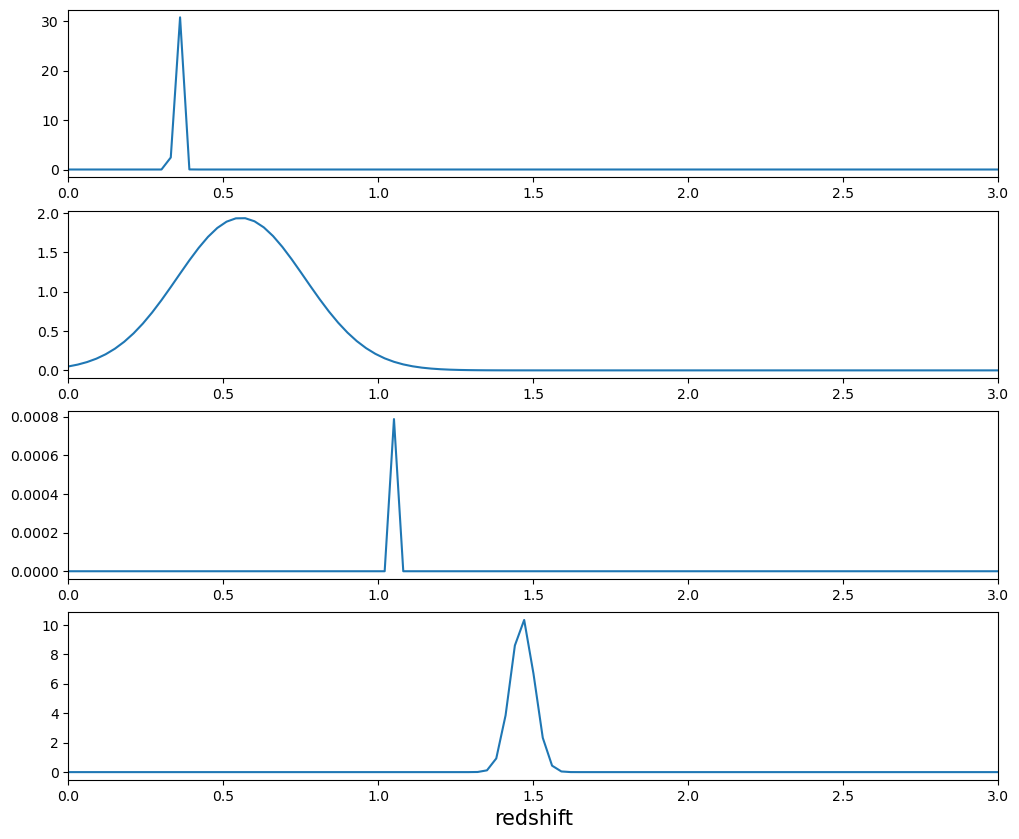

In [10]:
expdfids = [2, 180, 13517, 18032]
fig, axs = plt.subplots(4, 1, figsize=(12,10))
for i, xx in enumerate(expdfids):
    axs[i].set_xlim(0,3)
    ens[xx].plot_native(axes=axs[i])
axs[3].set_xlabel("redshift", fontsize=15)

GPzEstimator parameterizes each PDF as a single Gaussian, here we see a few examples of Gaussians of different widths.  Now let's grab the mode of each PDF (stored as ancil data in the ensemble) and compare to the true redshifts from the test_data file:

In [11]:
truez = test_data.data['photometry']['redshift']
zmode = ens.ancil['zmode'].flatten()

Text(0, 0.5, 'z mode')

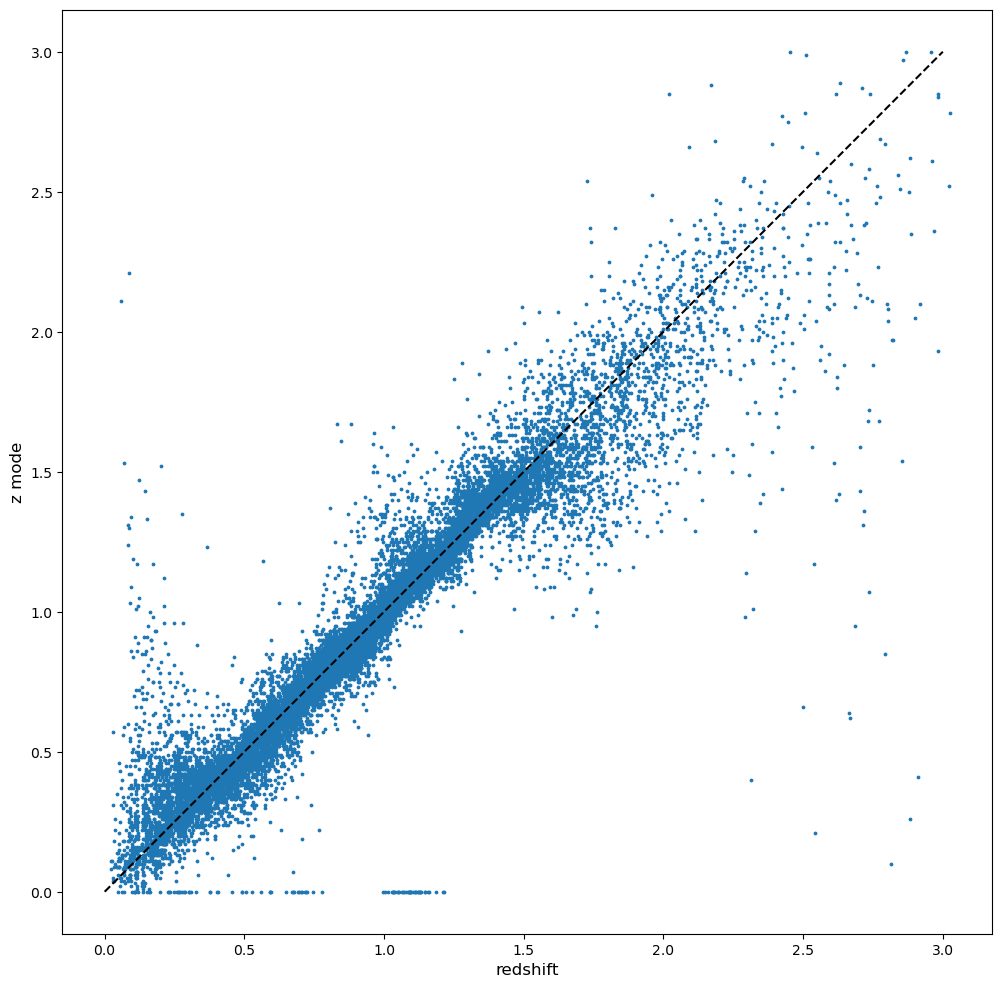

In [12]:
plt.figure(figsize=(12,12))
plt.scatter(truez, zmode, s=3)
plt.plot([0,3],[0,3], 'k--')
plt.xlabel("redshift", fontsize=12)
plt.ylabel("z mode", fontsize=12)